# Art generation using a variable auto-encoder
## Introduction
I have always enjoyed looking at art, however drawing and painting has always been out of my reach. So I decided to try creating images with a neural network! There are already many algorithms capable of creating new images. GANs can create images of new and absolutely realistic looking faces, or turn photos into paintings. But I wanted to try something new, I wanted to create images from a seed, just like Minecraft worlds. And even knowing that it would probably be impossible to create really good paintings, I still decided to try. 
## Used data and methods
For my project I found a dataset of paintings on Kaggle named “Painter by numbers” [1]. I used the “train” dataset and “all_data_info.csv” file. For my algorithm I picked VAE (variable autoencoder), since it would learn how to convert the images into latent space seeds and then turn the latent space seeds back into images. A trained model would then allow me to input seeds into latent space and watch as my neural network creates new images. I used Python, Tensorflow, Keras, Numpy, OpenCV, matplotlib and Pandas.


In [2]:
#Library import
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from os import listdir, replace, makedirs
from PIL import Image
Image.MAX_IMAGE_PIXELS = None #Needed for the neural net

## Image processing
The dataset is quite large, so it makes sense to load it into memory in batches. To create a dataset I used the ImageDataGenerator class from Keras. However, this class first loads the image, squeezes it into shape and then applies the function specified in the “preprocessing_function” parameter. I wanted the images to be cropped or padded before being squeezed into shape, so before using the generator I had to define and use my own function that would create a duplicate image with 1:1 ratio with either cropping or padding applied to it.

In [3]:
def image_square(path_from, path_to):
    """
    Function to create copes of images with copies having 1:1 aspect ratio
    
    Parameters:
    path_from : directory with original files
    path_to : directory to which the files will be saved
    """
    img_list = listdir(path_from)
    counter = 0
    for x in img_list:
        try:
            #Since this function can take a long time this code allows to track its progress
            if counter%1000==0:
                print('Image ' +str(counter)+ ' out of ' + str(len(img_list)))
            counter = counter+1
            
            img = cv2.imread(path_from+x) 
            dimension = max(img.shape[0:1]) #Getting the greater image dimension
            img = tf.image.resize_with_crop_or_pad(img, dimension,dimension)
            cv2.imwrite(path_to+x,np.asarray(img))
        except:
            print('Image ' + x + ' was not transformed')
# I only needed to use this function once, so the code calling it below is commented out
#image_square('ml project/train/','ImageGen/data/')


Then I used the ImageDataGenerator on the new image dataset.

In [4]:
# Defining the x and y dimension of the images
x_dim = 320
y_dim = 320
directory = 'data/train/'
image_list = listdir(directory)

train_datagen = ImageDataGenerator(
        rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'data/train/',
        target_size=(x_dim, y_dim),
        batch_size=50,
        class_mode=None)
print('Image array created')

Found 79418 images belonging to 103 classes.
Image array created


## Model definition and training
First I created the model using (and slightly modifying) the code from VAE tutorial provided by Keras [2].


In [5]:
#Start of code taken from the Keras tutorial:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
latent_dim = 5 # Initially there were 2 latent dimensions

encoder_inputs = keras.Input(shape=(x_dim, y_dim, 3)) #I chnaged number of channels to 3 (originally 1)
x = layers.Conv2D(32, 1, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 1, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
#In z_log_var I changed weight initialization to zero, because otherwise the loss would sometimes explode to infinity
z_log_var = layers.Dense(latent_dim, name="z_log_var",kernel_initializer = keras.initializers.Zeros())(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 32) 128         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 80, 64)   2112        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 409600)       0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [7]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(int(x_dim/4) * int(y_dim/4) * 64, activation="relu")(latent_inputs)
x = layers.Reshape((int(x_dim/4), int(y_dim/4), 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 409600)            2457600   
_________________________________________________________________
reshape (Reshape)            (None, 80, 80, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 160, 160, 64)      36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 320, 320, 32)      18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 320, 320, 3)       867       
Total params: 2,513,859
Trainable params: 2,513,859
Non-trainable params: 0
_________________________________________________

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    def call(self, inputs):
        x = inputs[0]
        y = inputs[1]
        for i in range(20):
            x = self.layers[i](x, y)
        return x
    
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [9]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
# End of code from Keras tutorial

The next step was training the model with the dataset I defined earlier.
<br><br>
**WARNING:** the model sometimes returns an error about wrong input dimensions, but all it takes to run the code correctly is to run the code cell below again. Since it's the simplest possible solution to this problem, I decided not to look for a different solution.

In [11]:
try:
    vae.load_weights('myWeights'+str(x_dim))
except:
        print('No weights found')
vae.fit(train_generator, epochs=5, steps_per_epoch=train_generator.samples/train_generator.batch_size)
vae.save_weights('myWeights'+str(x_dim))
print('Model complete')

No weights found
Epoch 1/5
1589/1588 [==============================] - 6165s 4s/step - loss: 512.4657 - reconstruction_loss: 512.4106 - kl_loss: 0.0551
Epoch 2/5
1589/1588 [==============================] - 6134s 4s/step - loss: 511.6788 - reconstruction_loss: 511.6680 - kl_loss: 0.0108
Epoch 3/5
1589/1588 [==============================] - 6117s 4s/step - loss: 511.5722 - reconstruction_loss: 511.5589 - kl_loss: 0.0133
Epoch 4/5
1589/1588 [==============================] - 6113s 4s/step - loss: 511.4950 - reconstruction_loss: 511.4842 - kl_loss: 0.0108
Epoch 5/5
1589/1588 [==============================] - 6109s 4s/step - loss: 511.4275 - reconstruction_loss: 511.4198 - kl_loss: 0.0077
Model complete


I generated new images and displayed them using the code below:

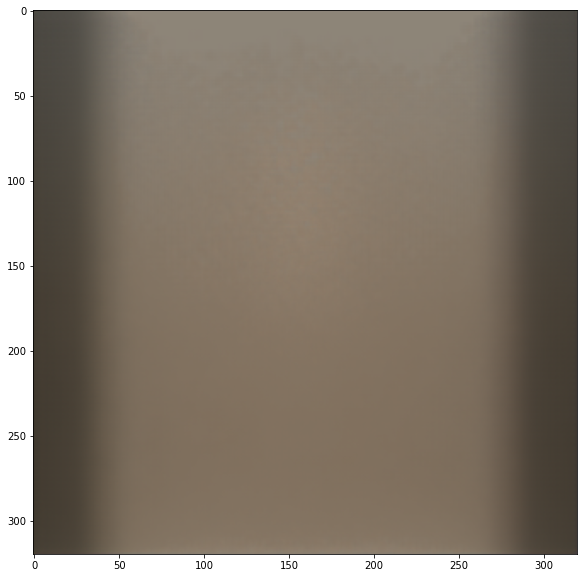

In [12]:
#Code used to visualize the outputs
z_sample = np.array([[0,0,0,0,0]])
x_decoded = decoder.predict(z_sample)
digit = x_decoded[0]
plt.figure(figsize=(10,10))
plt.imshow(digit)

<img src="files/markdown files/1.png">
<center><b>Fig. 1:</b> The first "artwork" generated by the network with 2 latent dimensions (on coordinates 20,20)</center>

## Further experimentation
After training the model for the first time I changed the data and training parameters many times to see what made the model perform better.
The first modification was increasing the number of latent space dimensions. At first I kept the number from the Keras tutorial, which was 2. I changed it from 2 to 3 and after noticing a decrease of loss and deconstruction loss I changed it to 5. Since the performance kept getting better, I changed it to 10, and at that point the performance got worse. In the end I decided to keep the number of latent dimensions at 5.
Another modification was splitting the data into categories. I didn’t think it woud have an effect, since it doesn’t really affect encoding the samples into latent space, but I decided to try it anyway. Splitting the data into categories was done using the code below:
**Test**


In [13]:
#Code usde to split image into categories
import pandas as pd
import errno
directory = 'data/train/'
image_list = listdir(directory)
file_info = pd.read_csv('all_data_info.csv')
def makeDirectory(path):
    try:
        makedirs(path)
    except:
        f = ''
def image_Categorizer():
    for i in image_list:
        path_from = directory+i
        #Some images had no genre, and I categorized them based on style
        genre = file_info[file_info['new_filename']==i]['genre'].values[0]
        style = file_info[file_info['new_filename']==i]['style'].values[0]
        if str(genre)=='nan':
            makeDirectory(directory+str(style))
            path_to = directory+str(style)+'/'+i
        else:
            makeDirectory(directory+str(genre))
            path_to = directory+str(genre)+'/'+i
            
        

        replace(path_from, path_to)
        
# image_Categorizer()

As expected it had absolutely no effect on the model performance.
Then I tried training the model on more (30 to be precise) epochs. Once again, the modification had almost no effect. While the loss values did decrease, the training took much longer and the generated images didn’t look any better than they did after 5 epochs, so I kept training o 5 epochs.
The next modification was changing the number on convolutional layers. Decreasing their number led to a decrease in image quality, so in the end I left the same model as was created in the Keras tutorial.
<img src="files/markdown files/2.png">
<center><b>Fig. 2:</b> Image generated with fewer layers</center>
<br>
<img src="files/markdown files/3.png">
<center><b>Fig. 3:</b> Image generated with more layers</center>
<br>
The last modification was training the model of a single category of images (I chose portrait), not all of them. This is where I got the best results, proving once again, that the main issue of this project is a too diversified dataset. 
<img src="files/markdown files/4.png">
<center><b>Fig. 4:</b> Image generated by a model exclusively trained on portrait art. If you look closely it seems similar to a female figure with long hair.</center>
<img src="files/markdown files/5.png">
<center><b>Fig. 5:</b> Another image generated by the same model, with slightly different latent dimensions coordinates</center>
<br>

## Conclusion
The most important parameter impacting the model’s performance was the number of latent space dimensions.
I knew the task of creating new images would be very difficult for a neural network, but I did expect it to do better. I know there are cases of successful MNIST image generation using VAE, so it is possible to generate images using these models. However it seems that artistic images were too diverse for the model to learn the patterns and convert them into latent space proved to be too difficult for my neural network. I still think the model could do well if it was given many very similar images for each class (for example 5000 images of a mountain and 5000 of a lake). For now I don’t have any ideas on how to improve this network’s performance, so I’m forced to leave it as it is.

## Sources
[1] https://www.kaggle.com/c/painter-by-numbers date of access 30.09.2020
[2] https://keras.io/examples/generative/vae/  date of access 30.09.2020
